<a href="https://colab.research.google.com/github/jojimenezt/project-NLP/blob/main/Primera_Entrega/Primera_Entrega_Proyecto_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# 📊 PREPROCESAMIENTO PLN DE ARCHIVO "Referencias OMIM.xlsx"
# ============================================================

# Instalación de librerías necesarias
!pip install spacy nltk wordcloud unidecode
!python -m spacy download en_core_web_sm

# ------------------------------------------------------------
# 1️⃣ IMPORTAR LIBRERÍAS
# ------------------------------------------------------------
import pandas as pd
import re
import nltk
import unidecode
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Descargar stopwords de NLTK
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# ------------------------------------------------------------
# CARGAR EL ARCHIVO
# ------------------------------------------------------------

file_path = "/content/Referencias OMIM.xlsx"  # cambia si tiene otro nombre
df = pd.read_excel(file_path)

# Verificamos las columnas
print("Columnas disponibles:")
print(df.columns)
print("\nPrimeras filas:")
display(df.head())

Columnas disponibles:
Index(['MIM number gen', 'Gen', 'ubicación', 'fenotipo', 'inherencia',
       'referencias', 'autor', 'titulo', 'abstract'],
      dtype='object')

Primeras filas:


,MIM number gen,Gen,ubicación,fenotipo,inherencia,referencias,autor,titulo,abstract
0,172411.0,PLA2G2A,1p36.13,cancer de colon,"AD, Smu",https://www.nature.com/articles/ng0997-88,"Robert T. Cormier, Karen H. Hong, Richard B. H...",Secretory phospholipase Pla2g2a confers resist...,Individuals inheriting the same mutation predi...
1,172411.0,PLA2G2A,1p36.14,cancer de colon,"AD, Smu",https://www.cell.com/cell/pdf/0092-8674(93)904...,"William F. Dietrich,’ Eric S. Lander,’ \nJenni...","Genetic Identification of Mom-l, \na Major Mod...",Mutations in the human APC gene cause various ...
2,172411.0,PLA2G2A,1p36.15,cancer de colon,"AD, Smu",https://link.springer.com/article/10.1007/s004...,"Zuzana Dobbie, Karl Heinimann, D. Tim Bishop, ...",Identification of a modifier gene locus on chr...,Phenotypic variability based on nonallelic het...
3,172411.0,PLA2G2A,1p36.16,cancer de colon,"AD, Smu",https://www.nature.com/articles/ng0997-7,Tommaso A. Dragani & Giacomo Manenti,Mom1 leads the pack,
4,172411.0,PLA2G2A,1p36.17,cancer de colon,"AD, Smu",https://gut.bmj.com/content/40/1/95,"M M Haapamäki, J M Grönroos, H Nurmi, K Alanen...",Gene expression of group II phospholipase A2 i...,It has been suggested that phospholipase A2 (P...


#Prepocesamiento: Entendimiento y preparación del conjunto de texto

In [ ]:
# ------------------------------------------------------------
# COMBINAR LAS COLUMNAS RELEVANTES (titulo, abstract, autor)
# ------------------------------------------------------------
df["texto"] = (
    df["titulo"].fillna("") + " " +
    df["abstract"].fillna("") + " " +
    df["autor"].fillna("")
)

In [ ]:
# ------------------------------------------------------------
# LIMPIEZA DE TEXTO
# ------------------------------------------------------------
def limpiar_texto(texto):
    texto = str(texto).lower()                              # minúsculas
    texto = unidecode.unidecode(texto)                      # quitar tildes
    texto = re.sub(r"http\S+|www\S+", "", texto)            # eliminar URLs
    texto = re.sub(r"[\\/]", " ", texto)                    # eliminar / y \
    texto = re.sub(r"[^a-z\s]", " ", texto)                 # eliminar caracteres no alfabéticos
    texto = re.sub(r"\b[a-z]\b", "", texto)                 # eliminar letras sueltas
    texto = re.sub(r"\s+", " ", texto).strip()              # quitar espacios extra
    return texto

df["texto_limpio"] = df["texto"].apply(limpiar_texto)

df["texto_limpio"] = df["texto"].apply(limpiar_texto)
print(df[["texto", "texto_limpio"]].head(10))


                                               texto  \
0  Secretory phospholipase Pla2g2a confers resist...   
1  Genetic Identification of Mom-l, \na Major Mod...   
2  Identification of a modifier gene locus on chr...   
3  Mom1 leads the pack   Tommaso A. Dragani & Gia...   
4  Gene expression of group II phospholipase A2 i...   
5  Phospholipase A2 group IIA expression in gastr...   
6  The Secretory Phospholipase A2 Gene Is a Candi...   
7  EcoRl and Nsil RFLPs at a human PLA2 gene on c...   
8  The Min (Multiple Intestinal Neoplasia) Mutati...   
9  ApcMin, a mutation in the murine Apc gene, pre...   

                                        texto_limpio  
0  secretory phospholipase pla confers resistance...  
1  genetic identification of mom major modifier l...  
2  identification of modifier gene locus on chrom...  
3  mom leads the pack tommaso dragani giacomo man...  
4  gene expression of group ii phospholipase in i...  
5  phospholipase group iia expression in gastrica... 

In [ ]:
# ------------------------------------------------------------
# TOKENIZACIÓN Y ELIMINACIÓN DE STOPWORDS
# ------------------------------------------------------------
stop_words = set(stopwords.words("english"))
custom_stopwords = {"study", "gene", "protein", "expression", "mutation", "analysis", "human", "disease", "cell"}

def tokenizar(texto):
    tokens = texto.split()
    tokens = [w for w in tokens if w not in stop_words and w not in custom_stopwords]
    return tokens

df["tokens"] = df["texto_limpio"].apply(tokenizar)

print(df[["texto_limpio", "tokens"]].head(10))

                                        texto_limpio  \
0  secretory phospholipase pla confers resistance...   
1  genetic identification of mom major modifier l...   
2  identification of modifier gene locus on chrom...   
3  mom leads the pack tommaso dragani giacomo man...   
4  gene expression of group ii phospholipase in i...   
5  phospholipase group iia expression in gastrica...   
6  the secretory phospholipase gene is candidate ...   
7  ecorl and nsil rflps at human pla gene on chro...   
8  the min multiple intestinal neoplasia mutation...   
9  apcmin mutation in the murine apc gene predisp...   

                                              tokens  
0  [secretory, phospholipase, pla, confers, resis...  
1  [genetic, identification, mom, major, modifier...  
2  [identification, modifier, locus, chromosome, ...  
3  [mom, leads, pack, tommaso, dragani, giacomo, ...  
4  [group, ii, phospholipase, intestine, ulcerati...  
5  [phospholipase, group, iia, gastricadenocarcin... 

In [ ]:
# ==========================
# LEMMATIZACIÓN Y STEMMING
# ==========================
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

def lematizar_y_stem(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    stems = [stemmer.stem(w) for w in lemmas]
    return stems

df["tokens_procesados"] = df["tokens"].apply(lematizar_y_stem)
print(df[["tokens", "tokens_procesados"]].head(10))

                                              tokens  \
0  [secretory, phospholipase, pla, confers, resis...   
1  [genetic, identification, mom, major, modifier...   
2  [identification, modifier, locus, chromosome, ...   
3  [mom, leads, pack, tommaso, dragani, giacomo, ...   
4  [group, ii, phospholipase, intestine, ulcerati...   
5  [phospholipase, group, iia, gastricadenocarcin...   
6  [secretory, phospholipase, candidate, morn, lo...   
7  [ecorl, nsil, rflps, pla, chromosome, pcb, kb,...   
8  [min, multiple, intestinal, neoplasia, effect,...   
9  [apcmin, murine, apc, predisposes, tomammary, ...   

                                   tokens_procesados  
0  [secretori, phospholipas, pla, confer, resist,...  
1  [genet, identif, mom, major, modifi, locu, aff...  
2  [identif, modifi, locu, chromosom, famili, ade...  
3  [mom, lead, pack, tommaso, dragani, giacomo, m...  
4  [group, ii, phospholipas, intestin, ulcer, col...  
5  [phospholipas, group, iia, gastricadenocarcino... 

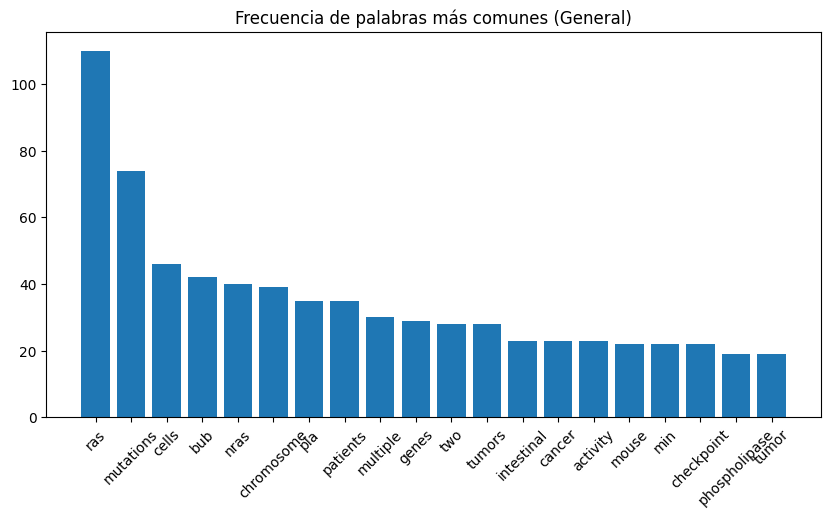

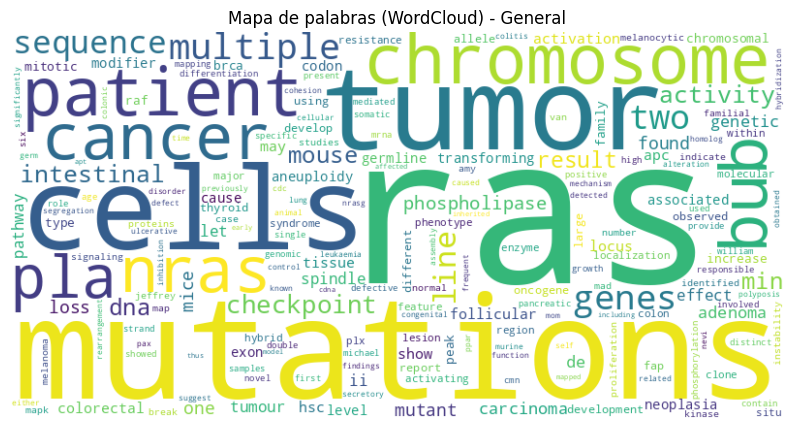

In [ ]:
# ------------------------------------------------------------
# FRECUENCIA GLOBAL DE PALABRAS
# ------------------------------------------------------------
todas_palabras = [p for tokens in df["tokens"] for p in tokens]
frecuencias = Counter(todas_palabras)
palabras_comunes = frecuencias.most_common(20)

# Gráfico de barras de frecuencia global
plt.figure(figsize=(10, 5))
plt.bar(*zip(*palabras_comunes))
plt.title("Frecuencia de palabras más comunes (General)")
plt.xticks(rotation=45)
plt.show()

# Nube de palabras general
wordcloud = WordCloud(
    width=800, height=400, background_color='white',
    collocations=False
).generate(" ".join(todas_palabras))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Mapa de palabras (WordCloud) - General")
plt.show()

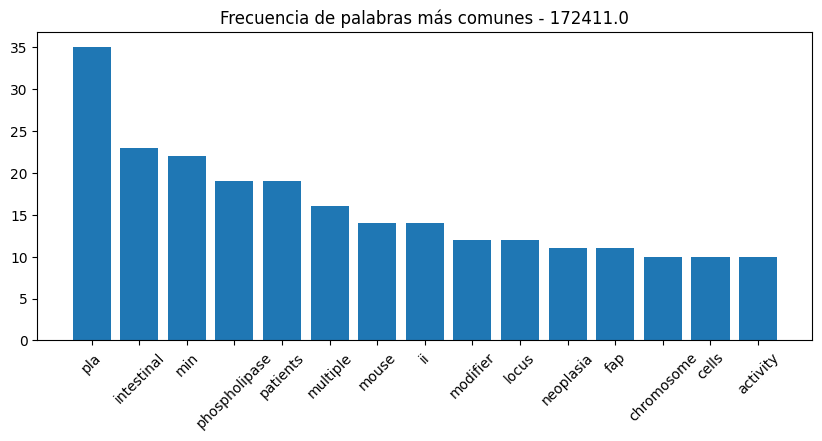

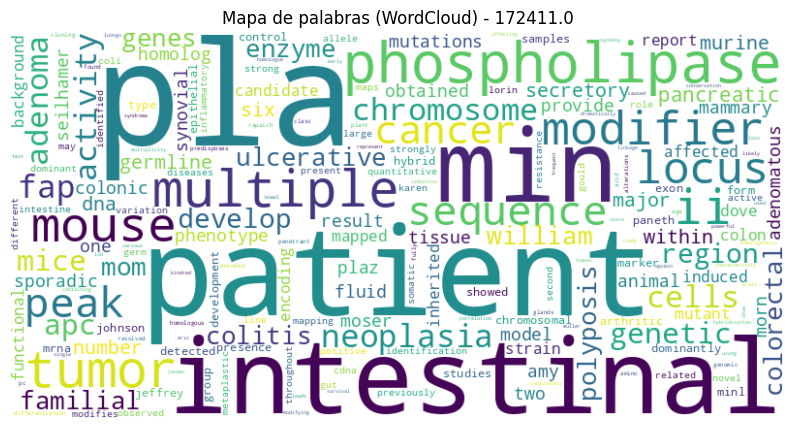

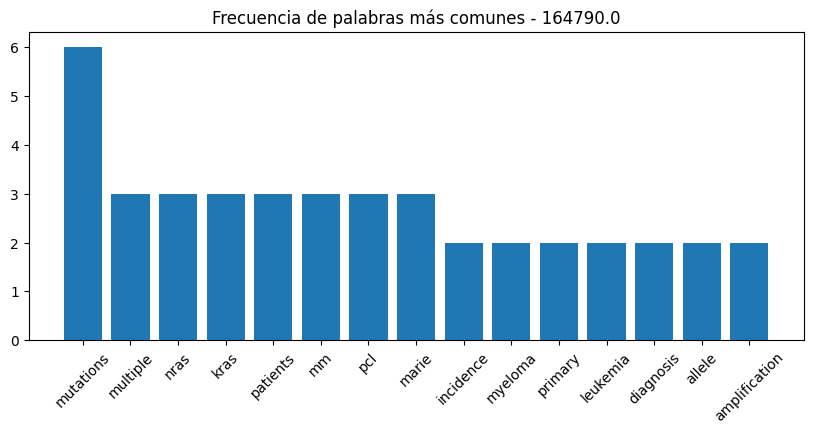

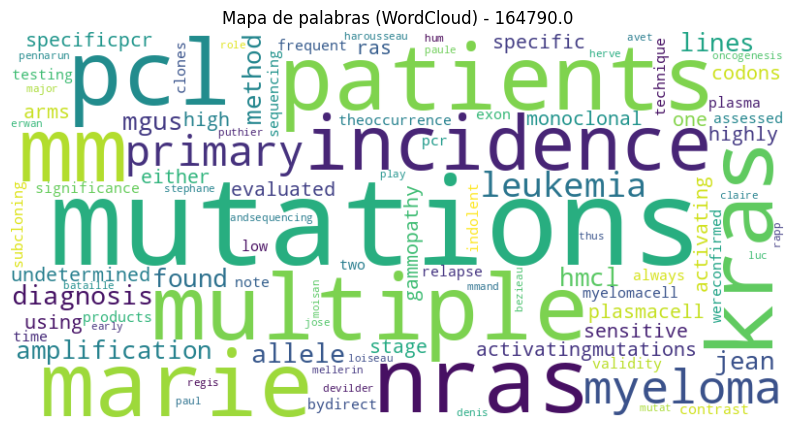

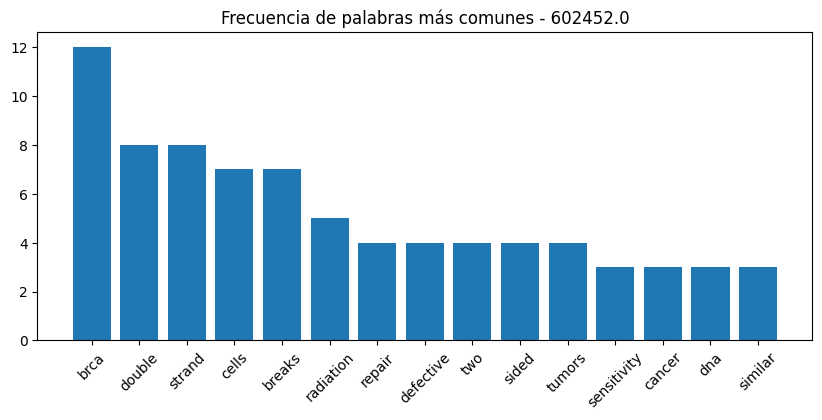

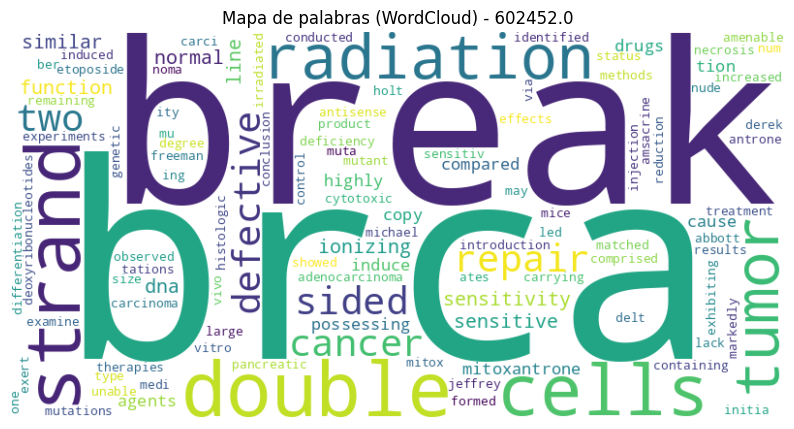

In [ ]:
# ------------------------------------------------------------
# ANÁLISIS POR GEN
# ------------------------------------------------------------
genes = df["MIM number gen"].unique()
resultados_gen = {}

for gen in genes:
    subset = df[df["MIM number gen"] == gen]
    palabras_gen = [p for tokens in subset["tokens"] for p in tokens]
    if not palabras_gen:
        continue

    frecuencias_gen = Counter(palabras_gen).most_common(15)
    resultados_gen[gen] = frecuencias_gen

    # Gráfico de barras por gen
    plt.figure(figsize=(10, 4))
    plt.bar(*zip(*frecuencias_gen))
    plt.title(f"Frecuencia de palabras más comunes - {gen}")
    plt.xticks(rotation=45)
    plt.show()

    # Nube de palabras por gen
    wordcloud_gen = WordCloud(
        width=800, height=400, background_color='white',
        collocations=False
    ).generate(" ".join(palabras_gen))

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud_gen, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Mapa de palabras (WordCloud) - {gen}")
    plt.show()

##Transformación del texto para extracción de características

In [ ]:
# ==========================
# EXTRACCIÓN DE CARACTERÍSTICAS Y VECTORIZACIÓN
# ==========================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Volvemos a unir los tokens procesados en texto
df["texto_final"] = df["tokens_procesados"].apply(lambda x: " ".join(x))

# --------------------------
# Estrategia 1: Bag of Words (BoW)
# --------------------------
bow_vectorizer = CountVectorizer(max_features=1000)  # puedes ajustar el número de características
X_bow = bow_vectorizer.fit_transform(df["texto_final"])

# Mostrar las primeras palabras seleccionadas como features
print("🔹 Palabras seleccionadas (BoW):")
print(bow_vectorizer.get_feature_names_out()[:30])

# --------------------------
# Estrategia 2: TF-IDF
# --------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df["texto_final"])

print("\n🔹 Palabras seleccionadas (TF-IDF):")
print(tfidf_vectorizer.get_feature_names_out()[:30])

# Convertir a DataFrame para visualizar
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()


🔹 Palabras seleccionadas (BoW):
['aaronson' 'abhd' 'abl' 'abnorm' 'absenc' 'absent' 'abu' 'abund'
 'acceler' 'accord' 'account' 'accumul' 'acid' 'acquaviva' 'acquir'
 'acquisit' 'act' 'activ' 'acut' 'acyl' 'addit' 'adenoma' 'adenomat'
 'affect' 'age' 'agent' 'aim' 'akr' 'al' 'alan']

🔹 Palabras seleccionadas (TF-IDF):
['aaronson' 'abhd' 'abl' 'abnorm' 'absenc' 'absent' 'abu' 'abund'
 'acceler' 'accord' 'account' 'accumul' 'acid' 'acquaviva' 'acquir'
 'acquisit' 'act' 'activ' 'acut' 'acyl' 'addit' 'adenoma' 'adenomat'
 'affect' 'age' 'agent' 'aim' 'akr' 'al' 'alan']


,aaronson,abhd,abl,abnorm,absenc,absent,abu,abund,acceler,accord,...,yuji,yujiro,yuri,yuxiao,yuya,zahradnik,zampino,zation,zecca,zhanyun
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


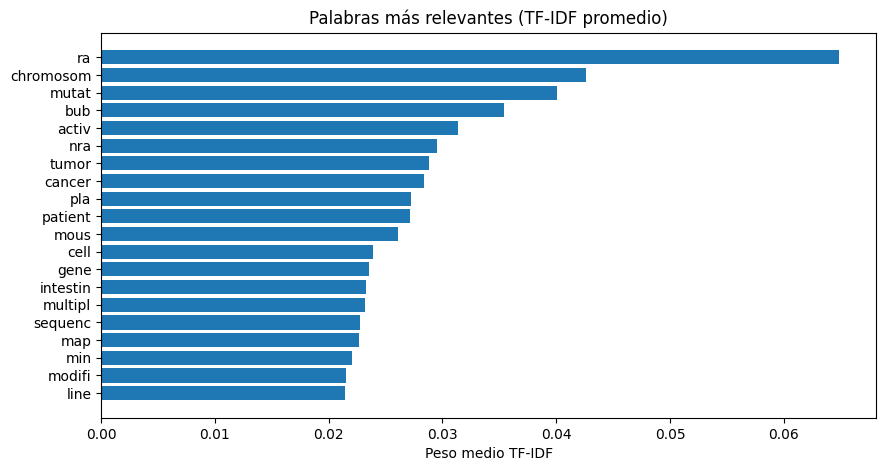

In [ ]:
# Promedio de importancia de cada palabra
import numpy as np
promedios = np.asarray(X_tfidf.mean(axis=0)).ravel()
palabras = tfidf_vectorizer.get_feature_names_out()

# Tomamos las 20 más relevantes
top_indices = promedios.argsort()[-20:][::-1]
plt.figure(figsize=(10,5))
plt.barh(np.array(palabras)[top_indices], promedios[top_indices])
plt.gca().invert_yaxis()
plt.title("Palabras más relevantes (TF-IDF promedio)")
plt.xlabel("Peso medio TF-IDF")
plt.show()


##Modelo de aprendizaje Supervisado

In [ ]:
# --------------------------
# Crear dataset de entrenamiento NER
# --------------------------

# Crear la columna 'texto_ner' combinando título, abstract y autor
df["texto_ner"] = (
    df["titulo"].fillna('') + ". " +
    df["abstract"].fillna('') + ". " +
    df["autor"].fillna('')
)

TRAIN_DATA = []

for _, row in df.iterrows():
    texto = row["texto_ner"]
    gen = str(row["MIM number gen"]).strip()

    # Buscar la posición del gen en el texto
    if gen and gen.lower() in texto.lower():
        start = texto.lower().find(gen.lower())
        end = start + len(gen)
        TRAIN_DATA.append((texto, {"entities": [(start, end, "GENE")]}))


In [ ]:
# --------------------------
# Entrenamiento del modelo NER (spaCy)
# --------------------------

import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import random

# Crear modelo base en inglés
nlp = spacy.blank("en")

# Crear pipeline de NER
ner = nlp.add_pipe("ner")

# Agregar etiquetas
ner.add_label("GENE")

# Entrenamiento
optimizer = nlp.begin_training()

for itn in range(20):
    random.shuffle(TRAIN_DATA)
    losses = {}
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        examples = [Example.from_dict(nlp.make_doc(t), a) for t, a in zip(texts, annotations)]
        nlp.update(examples, drop=0.3, losses=losses)
    print(f"Iteración {itn+1} - Pérdida: {losses['ner']:.4f}")


/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Multiple Congenital Melanocytic Nevi and Neurocuta..." with entities "[(1407, 1410, 'GENE')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Localisation of the human N-ras oncogene to chromo..." with entities "[(510, 513, 'GENE')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Heterozygosity for a Bub1 mutation causesfe

Iteración 1 - Pérdida: 2576.2007
Iteración 2 - Pérdida: 1969.1821
Iteración 3 - Pérdida: 733.9001
Iteración 4 - Pérdida: 45.1432
Iteración 5 - Pérdida: 0.1933
Iteración 6 - Pérdida: 0.0000
Iteración 7 - Pérdida: 0.0000
Iteración 8 - Pérdida: 0.0000
Iteración 9 - Pérdida: 0.0000
Iteración 10 - Pérdida: 0.0000
Iteración 11 - Pérdida: 0.0000
Iteración 12 - Pérdida: 0.0000
Iteración 13 - Pérdida: 0.0000
Iteración 14 - Pérdida: 0.0000
Iteración 15 - Pérdida: 0.0000
Iteración 16 - Pérdida: 0.0000
Iteración 17 - Pérdida: 0.0000
Iteración 18 - Pérdida: 0.0000
Iteración 19 - Pérdida: 0.0000
Iteración 20 - Pérdida: 0.0000


In [ ]:
# --------------------------
# Guardar el modelo entrenado
# -------------------------

nlp.to_disk("modelo_genes")

# Cargar modelo entrenado
modelo_genes = spacy.load("modelo_genes")

# Probar en nuevo texto
texto_prueba = "Recent studies identified mutations in TP53 and BRCA2 genes."
doc = modelo_genes(texto_prueba)

print("🧬 Entidades encontradas:")
for ent in doc.ents:
    print(ent.text, ent.label_)


🧬 Entidades encontradas:
